In [1]:
class_names = ['0', '1', '2',  '3', '4', 
          '5', '6', '7',  '8','9']

num_classes = len(class_names)

In [2]:
from os import path
from collections.abc import Iterable
from keras.utils import Sequence
from utils import tools

class Yolo_data(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.class_names = class_names
        self.class_num = len(class_names)
        self.fpn_layers = 3
        self.file_names = None
        
    def read_file_to_dataset(
        self, img_path=None, label_path=None,
        label_format="labelimg",
        rescale=1/255,
        preprocessing=None,
        augmenter=None,
        aug_times=1,
        shuffle=True, seed=None,
        encoding="big5",
        thread_num=10):
        
        grid_amp = 2**(self.fpn_layers - 1)
        grid_shape = (self.grid_shape[0]*grid_amp,
                      self.grid_shape[1]*grid_amp)
        img_data, label_data, path_list = tools.read_file(
            img_path=img_path, 
            label_path=label_path,
            label_format=label_format,
            size=self.input_shape[:2], 
            grid_shape=grid_shape,
            class_names=self.class_names,
            rescale=rescale,
            preprocessing=preprocessing,
            augmenter=augmenter,
            aug_times=aug_times,
            shuffle=shuffle, seed=seed,
            encoding=encoding,
            thread_num=thread_num)
        self.file_names = path_list

        label_list = [label_data]
        for _ in range(self.fpn_layers - 1):
            label_data = tools.down2xlabel(label_data)
            label_list.insert(0, label_data)

        return img_data, label_list
    def vis_img(self, img, *label_datas,
                conf_threshold=0.5,
                show_conf=True,
                nms_mode=0,
                nms_threshold=0.5,
                nms_sigma=0.5,
                **kwargs):

        return tools.vis_img(
                             img, 
                             *label_datas, 
                             class_names=self.class_names,
                             conf_threshold=conf_threshold,
                             show_conf=show_conf,
                             nms_mode=nms_mode,  
                             nms_threshold=nms_threshold,
                             nms_sigma=nms_sigma,
                             version=3,
                             **kwargs)

In [3]:
yolo_data = Yolo_data(class_names=class_names)

img_path   = "../01_1K_MNIST/mnist_train/"
label_path = "../01_1K_MNIST/xml_train/"

train_img, train_label = yolo_data.read_file_to_dataset(
    img_path, label_path,
    thread_num=50,
    shuffle=False)

img_path   = "../01_1K_MNIST/mnist_val/"
label_path = "../01_1K_MNIST/xml_val/"

test_img, test_label = yolo_data.read_file_to_dataset(
    img_path, label_path,
    thread_num=50,
    shuffle=False)

valid_img  = test_img
valid_label = test_label

Notice! Repeat!: 000945.jpg 42 33


In [4]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, UpSampling2D, Concatenate, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import get_file

from functools import wraps, reduce

from keras.layers import concatenate, Add, ZeroPadding2D, LeakyReLU, BatchNormalization
from keras.regularizers import l2
import numpy as np

## Hyperparameter
n_epoch = 10
keep_prob = 0.7

In [5]:
###DropBlock
from keras import backend as K
import tensorflow as tf
from keras.layers import Layer
# from keras.src.layers import Layer

def _bernoulli(shape, mean):
    return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))

class DropBlock2D(Layer):
    def __init__(self, keep_prob, block_size, scale=True,name=None, **kwargs):
        super(DropBlock2D, self).__init__(name="DropBlock2D")
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
        self.names = name
        self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale
        super(DropBlock2D, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update( {"block_size": self.block_size,"keep_prob": self.keep_prob,"name": self.names })

        return config

    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        assert len(input_shape) == 4
        _, self.h, self.w, self.channel = input_shape.as_list()
        # pad the mask
        p1 = (self.block_size - 1) // 2
        p0 = (self.block_size - 1) - p1
        self.padding = [[0, 0], [p0, p1], [p0, p1], [0, 0]]
        self.set_keep_prob()
        super(DropBlock2D, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            output = inputs * mask
            output = tf.cond(self.scale,
                             true_fn=lambda: output *tf.cast(tf.size(mask), dtype=tf.float32)  / tf.reduce_sum(mask),
                             false_fn=lambda: output)
            return output

        if training is None:
            training = K.learning_phase()
        # output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
        output = tf.cond(tf.logical_or(tf.logical_not(bool(training)), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        w, h = tf.cast(self.w, dtype=tf.float32), tf.cast(self.h, dtype=tf.float32)
        
        self.gamma = (1. - self.keep_prob) * (w * h) / (self.block_size ** 2) / \
                     ((w - self.block_size + 1) * (h - self.block_size + 1))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                       self.h - self.block_size + 1,
                                       self.w - self.block_size + 1,
                                       self.channel])
        mask = _bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool(mask, [1, self.block_size, self.block_size, 1], [1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask

In [6]:
### Leaky Convolutional
def compose(*funcs):
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')
    
@wraps(Conv2D)
def DarknetConv2D(*args, **kwargs):
    '''Wrapper to set Darknet parameters for Convolution2D.'''
    darknet_conv_kwargs = {'kernel_initializer': 'he_normal'}
    if kwargs.get('strides') == (2, 2):
        darknet_conv_kwargs['padding'] = 'valid'
    else:
        darknet_conv_kwargs['padding'] = 'same'
    darknet_conv_kwargs.update(kwargs)
    return Conv2D(*args, **darknet_conv_kwargs)

def DarknetConv2D_BN_Leaky(*args, **kwargs):
    '''Darknet Convolution2D followed by BatchNormalization and LeakyReLU.'''
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))

In [7]:
## Residual Block
def resblock_body(x, num_filters, num_blocks):
    '''A series of resblocks starting with a downsampling Convolution2D'''
    # Darknet uses left and top padding instead of 'same' mode
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)
    x = DarknetConv2D_BN_Leaky(num_filters, (3, 3), strides=(2, 2))(x)
    x = DropBlock2D(keep_prob=keep_prob, block_size=3)(x)
    for _ in range(num_blocks):
        y = compose(
            DarknetConv2D_BN_Leaky(num_filters//2, (1, 1)),
            DropBlock2D(keep_prob=keep_prob, block_size=3),
            DarknetConv2D_BN_Leaky(num_filters, (3, 3)))(x)
        x = Add()([x, y])
    return x

In [8]:
## Backbone Darknet
def Backbone_darknet(input_tensor):
    '''Darknent body having 52 Convolution2D layers'''
    x = DarknetConv2D_BN_Leaky(32, (3, 3))(input_tensor)
    x = resblock_body(x, 64, 1)
    x = resblock_body(x, 128, 2)
    x = resblock_body(x, 256, 8)
    x = resblock_body(x, 512, 8)
    x = resblock_body(x, 1024, 4)
    return x


def make_last_layers(x, num_filters):
    '''6 Conv2D_BN_Leaky layers followed by a Conv2D_linear layer'''
    x = compose(
            DarknetConv2D_BN_Leaky(num_filters, (1, 1)),
            DropBlock2D(keep_prob=keep_prob, block_size=3),
            DarknetConv2D_BN_Leaky(num_filters*2, (3, 3)),
            DropBlock2D(keep_prob=keep_prob, block_size=3),
            DarknetConv2D_BN_Leaky(num_filters, (1, 1)),
            DropBlock2D(keep_prob=keep_prob, block_size=3),
            DarknetConv2D_BN_Leaky(num_filters*2, (3, 3)),
            DropBlock2D(keep_prob=keep_prob, block_size=3),
            DarknetConv2D_BN_Leaky(num_filters, (1, 1)))(x)
    y = DarknetConv2D_BN_Leaky(num_filters*2, (3, 3))(x)
    return x, y

In [9]:
### YOLO Neck
def yolo_neck(input_shape=(416, 416, 3),
              pretrained_darknet=None,
              pretrained_weights=None):
    '''Create YOLO_V3 model CNN body in Keras.'''
    inputs = Input(input_shape)
    darknet = Model(inputs, Backbone_darknet(inputs))
    if pretrained_darknet is not None:
        darknet.set_weights(pretrained_darknet.get_weights())
    
    x, y1 = make_last_layers(darknet.output, 512)

    x = compose(
            DarknetConv2D_BN_Leaky(256, (1,1)),
            UpSampling2D(2))(x)
    x = Concatenate()([x, darknet.layers[152].output])
    x, y2 = make_last_layers(x, 256)

    x = compose(
            DarknetConv2D_BN_Leaky(128, (1,1)),
            UpSampling2D(2))(x)
    x = Concatenate()([x, darknet.layers[92].output])
    x, y3 = make_last_layers(x, 128)
    model = Model(inputs, [y1, y2, y3])
    
    '''
    if pretrained_weights is not None:
        if pretrained_weights == "pascal_voc":
            pretrained_weights = get_file(
                "tf_keras_yolov3_body.h5",
                WEIGHTS_PATH_DN_BODY,
                cache_subdir="models")
        model.load_weights(pretrained_weights)
    ''' 
    return model

In [10]:
### YOLO Head
def yolo_head(model_body, class_num=10, 
              anchors=[[0.89663461, 0.78365384],
                       [0.37500000, 0.47596153],
                       [0.27884615, 0.21634615],
                       [0.14182692, 0.28605769],
                       [0.14903846, 0.10817307],
                       [0.07211538, 0.14663461],
                       [0.07932692, 0.05528846],
                       [0.03846153, 0.07211538],
                       [0.02403846, 0.03125000]]):
    anchors = np.array(anchors)
    inputs = model_body.input
    output = model_body.output
    tensor_num = len(output)

    if len(anchors)%tensor_num > 0:
        raise ValueError(("The total number of anchor boxs"
                          " should be a multiple of the number(%s)"
                          " of output tensors") % tensor_num)    
    abox_num = len(anchors)//tensor_num

    outputs_list = []
    for tensor_i, output_tensor in enumerate(output):
        output_list = []
        start_i = tensor_i*abox_num
        for box in anchors[start_i:start_i + abox_num]:
            xy_output = DarknetConv2D(2, 1,
                            activation='sigmoid')(output_tensor)
            wh_output = DarknetConv2D(2, 1,
                            activation='exponential')(output_tensor)
            wh_output = wh_output * box
            c_output = DarknetConv2D(1, 1,
                            activation='sigmoid')(output_tensor)
            p_output = DarknetConv2D(class_num, 1,
                            activation='sigmoid')(output_tensor)
            output_list += [xy_output,
                            wh_output,
                            c_output,
                            p_output]

        outputs = concatenate(output_list, axis=-1)
        outputs_list.append(outputs)
    
    model = Model(inputs, outputs_list)    

    return model

In [11]:
epsilon = 1e-07
## IoU
def cal_iou(xywh_true, xywh_pred, grid_shape):
    grid_shape = np.array(grid_shape[::-1])
    xy_true = xywh_true[..., 0:2]/grid_shape # N*S*S*1*2
    wh_true = xywh_true[..., 2:4]

    xy_pred = xywh_pred[..., 0:2]/grid_shape # N*S*S*B*2
    wh_pred = xywh_pred[..., 2:4]
    
    half_xy_true = wh_true / 2.
    mins_true    = xy_true - half_xy_true
    maxes_true   = xy_true + half_xy_true

    half_xy_pred = wh_pred / 2.
    mins_pred    = xy_pred - half_xy_pred
    maxes_pred   = xy_pred + half_xy_pred       
    
    intersect_mins  = tf.maximum(mins_pred,  mins_true)
    intersect_maxes = tf.minimum(maxes_pred, maxes_true)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = wh_true[..., 0] * wh_true[..., 1]
    pred_areas = wh_pred[..., 0] * wh_pred[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = (intersect_areas + epsilon)/(union_areas + epsilon)
    
    return iou_scores

In [12]:
### Yolo Loss Function
def wrap_yolo_loss(grid_shape,
                   bbox_num,
                   class_num,
                   anchors,
                   binary_weight=1,
                   loss_weight=[1, 1, 1, 1],
                   ignore_thresh=.6,
                   ):
    def yolo_loss(y_true, y_pred):
        panchors = tf.reshape(anchors, (1, 1, 1, bbox_num, 2))

        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*(5+C)
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*(5+C)

        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        
        response_mask = tf.one_hot(tf.argmax(iou_scores, axis=-1),
                                   depth=bbox_num,
                                   dtype=xywh_true.dtype) # N*S*S*B

        has_obj_mask = y_true[..., 4]*response_mask # N*S*S*B
        has_obj_mask_exp = tf.expand_dims(has_obj_mask, axis=-1) # N*S*S*B*1

        no_obj_mask = tf.cast(
            iou_scores < ignore_thresh,
            iou_scores.dtype) # N*S*S*B
        no_obj_mask = (1 - has_obj_mask)*no_obj_mask # N*S*S*B

        xy_true = y_true[..., 0:2] # N*S*S*1*2
        xy_pred = y_pred[..., 0:2] # N*S*S*B*2

        wh_true = tf.maximum(y_true[..., 2:4]/panchors, epsilon) # N*S*S*1*2
        wh_pred = y_pred[..., 2:4]/panchors
        
        wh_true = tf.math.log(wh_true) # N*S*S*B*2
        wh_pred = tf.math.log(wh_pred) # N*S*S*B*2

        c_pred = y_pred[..., 4] # N*S*S*B

        box_loss_scale = 2 - y_true[..., 2:3]*y_true[..., 3:4] # N*S*S*1*1

        xy_loss = tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *box_loss_scale # N*S*S*1*1
                *tf.square(xy_true - xy_pred), # N*S*S*B*2
                axis=0))

        wh_loss = tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *box_loss_scale # N*S*S*1*1
                *tf.square(wh_true - wh_pred), # N*S*S*B*2
                axis=0))

        has_obj_c_loss = tf.reduce_sum(
                tf.reduce_mean(
                has_obj_mask # N*S*S*1
                *(tf.square(1 - c_pred)), # N*S*S*B
                axis=0))

        no_obj_c_loss = tf.reduce_sum(
                tf.reduce_mean(
                no_obj_mask # N*S*S*1
                *(tf.square(0 - c_pred)), # N*S*S*B
                axis=0))
        
        c_loss = has_obj_c_loss + binary_weight*no_obj_c_loss

        p_true = y_true[..., -class_num:] # N*S*S*1*C
        p_pred = y_pred[..., -class_num:] # N*S*S*B*C
        p_pred = tf.clip_by_value(p_pred, epsilon, 1 - epsilon)
        p_loss = -tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *(p_true*tf.math.log(p_pred)
                + (1 - p_true)*tf.math.log(1 - p_pred)), # N*S*S*B*C
                axis=0))
        
        regularizer = tf.reduce_sum(
            tf.reduce_mean(wh_pred**2, axis=0))*0.01

        loss = (loss_weight[0]*xy_loss
                + loss_weight[1]*wh_loss
                + loss_weight[2]*c_loss
                + loss_weight[3]*p_loss
                + regularizer)

        return loss

    return yolo_loss

In [13]:
## Object Accuracy
from keras.metrics import binary_accuracy
def wrap_obj_acc(grid_shape, bbox_num, class_num):
    def obj_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C
        
        c_true = y_true[..., 4] # N*S*S*1
        c_pred = tf.reduce_max(y_pred[..., 4], # N*S*S*B
                               axis=-1,
                               keepdims=True) # N*S*S*1

        bi_acc = binary_accuracy(c_true, c_pred)

        return bi_acc
    return obj_acc

In [14]:
### Mean IoU
def wrap_mean_iou(grid_shape, bbox_num, class_num):
    def mean_iou(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1
        
        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        iou_scores = tf.reduce_max(iou_scores, axis=-1, keepdims=True) # N*S*S*1
        iou_scores = iou_scores*has_obj_mask # N*S*S*1

        num_p = tf.reduce_sum(has_obj_mask)

        return tf.reduce_sum(iou_scores)/(num_p + epsilon)
    return mean_iou

In [15]:
## Class Accuracy
def wrap_class_acc(grid_shape, bbox_num, class_num):
    def class_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1

        pi_true = tf.argmax(y_true[..., -class_num:], # N*S*S*1*C
                            axis=-1) # N*S*S*1
        pi_pred = tf.argmax(y_pred[..., -class_num:], # N*S*S*B*C
                            axis=-1) # N*S*S*B
        
        equal_mask = tf.cast(pi_true == pi_pred,
                             dtype=y_true.dtype) # N*S*S*B
        equal_mask = equal_mask*has_obj_mask # N*S*S*B

        num_p = tf.reduce_sum(has_obj_mask)*bbox_num

        return tf.reduce_sum(equal_mask)/(num_p + epsilon)
    return class_acc

In [16]:
## Build Class for Model, Loss, Metrics
class Yolo(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.abox_num = 3
        self.class_names = class_names
        self.class_num = len(class_names)
        self.fpn_layers = 3
        self.anchors = None
        self.model = None
        self.file_names = None

    """
    Model Create
    """
    def create_model(self,
                     anchors=[[0.89663461, 0.78365384],
                              [0.37500000, 0.47596153],
                              [0.27884615, 0.21634615],
                              [0.14182692, 0.28605769],
                              [0.14903846, 0.10817307],
                              [0.07211538, 0.14663461],
                              [0.07932692, 0.05528846],
                              [0.03846153, 0.07211538],
                              [0.02403846, 0.03125000]],
                     backbone="full_darknet",
                     pretrained_weights=None,
                     pretrained_darknet="pascal_voc"):
        
        if isinstance(pretrained_darknet, str):
            pre_body_weights = pretrained_darknet
            pretrained_darknet = None
        else:
            pre_body_weights = None
        
        model_body = yolo_neck(self.input_shape,
            pretrained_weights=pre_body_weights)

        if pretrained_darknet is not None:
            model_body.set_weights(pretrained_darknet.get_weights())
        self.model = yolo_head(model_body,
                               self.class_num,
                               anchors)
         
        if pretrained_weights is not None:
            self.model.load_weights(pretrained_weights)
        self.anchors = anchors
        self.grid_shape = self.model.output[0].shape[1:3]
        self.fpn_layers = len(self.model.output)
        self.abox_num = len(self.anchors)//self.fpn_layers

    """
    Loss Create
    """
    def loss(self,
             binary_weight=1,
             loss_weight=[1, 1, 5, 1],
             ignore_thresh=0.6):

        if (not isinstance(binary_weight, Iterable)
            or len(binary_weight) != self.fpn_layers):
            binary_weight = [binary_weight]*self.fpn_layers
        
        if isinstance(loss_weight, dict):
            loss_weight_list = []
            loss_weight_list.append(loss_weight["xy"])
            loss_weight_list.append(loss_weight["wh"])
            loss_weight_list.append(loss_weight["conf"])
            loss_weight_list.append(loss_weight["prob"])
            loss_weight = loss_weight_list
        
        loss_list = []
        for fpn_id in range(self.fpn_layers):
            grid_amp = 2**(fpn_id)
            grid_shape = (self.grid_shape[0]*grid_amp,
                          self.grid_shape[1]*grid_amp)
            anchors_id = self.abox_num*fpn_id
            loss_list.append(wrap_yolo_loss(
                grid_shape=grid_shape,
                bbox_num=self.abox_num, 
                class_num=self.class_num,
                anchors=self.anchors[
                    anchors_id:anchors_id + self.abox_num],
                binary_weight=binary_weight[fpn_id],
                loss_weight=loss_weight,
                ignore_thresh=ignore_thresh))
        return loss_list
    
    """
    Metrics Create
    """
    def metrics(self, type="obj_acc"):
        
        
        metrics_list = [[] for _ in range(self.fpn_layers)]
        for fpn_id in range(self.fpn_layers):
            grid_amp = 2**(fpn_id)
            grid_shape = (self.grid_shape[0]*grid_amp,
                            self.grid_shape[1]*grid_amp)
            
            if "obj" in type:
                metrics_list[fpn_id].append(
                    wrap_obj_acc(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
            if "iou" in type:
                metrics_list[fpn_id].append(
                    wrap_mean_iou(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
            if "class" in type:
                metrics_list[fpn_id].append(
                    wrap_class_acc(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
        
        return metrics_list

epoch  1: loss = 0.5723
epoch  2: loss = 0.2200
epoch  3: loss = 0.2395
epoch  4: loss = 0.0959
epoch  5: loss = 0.1181
epoch  6: loss = 0.1256
epoch  7: loss = 0.1375
epoch  8: loss = 0.1217
epoch  9: loss = 0.1063
epoch 10: loss = 0.1824
epoch 11: loss = 0.1401
epoch 12: loss = 0.1703
epoch 13: loss = 0.1012
epoch 14: loss = 0.1413
epoch 15: loss = 0.1552
epoch 16: loss = 0.1272
epoch 17: loss = 0.0169
epoch 18: loss = 0.0898
epoch 19: loss = 0.1481
epoch 20: loss = 0.1782
epoch 21: loss = 0.1347
epoch 22: loss = 0.0520
epoch 23: loss = 0.1182
epoch 24: loss = 0.1384
epoch 25: loss = 0.1378
epoch 26: loss = 0.0828
epoch 27: loss = 0.1039
epoch 28: loss = 0.1058
epoch 29: loss = 0.1280
epoch 30: loss = 0.1172
epoch 31: loss = 0.0412
epoch 32: loss = 0.1177
epoch 33: loss = 0.1372
epoch 34: loss = 0.1189
epoch 35: loss = 0.0623
epoch 36: loss = 0.1178
epoch 37: loss = 0.1577
epoch 38: loss = 0.0495
epoch 39: loss = 0.0937
epoch 40: loss = 0.0947
epoch 41: loss = 0.0671
epoch 42: loss =

epoch 200: loss = 0.1362
epoch 201: loss = 0.1566
epoch 202: loss = 0.1611
epoch 203: loss = 0.1671
epoch 204: loss = 0.1928
epoch 205: loss = 0.1967
epoch 206: loss = 0.1310
epoch 207: loss = 0.0726
epoch 208: loss = 0.0673
epoch 209: loss = 0.0434
epoch 210: loss = 0.1208
epoch 211: loss = 0.1242
epoch 212: loss = 0.1391
epoch 213: loss = 0.1090
epoch 214: loss = 0.1603
epoch 215: loss = 0.0517
epoch 216: loss = 0.0594
epoch 217: loss = 0.1462
epoch 218: loss = 0.0664
epoch 219: loss = 0.0833
epoch 220: loss = 0.1480
epoch 221: loss = 0.1330
epoch 222: loss = 0.1132
epoch 223: loss = 0.1804
epoch 224: loss = 0.0969
epoch 225: loss = 0.1382
epoch 226: loss = 0.0917
epoch 227: loss = 0.1060
epoch 228: loss = 0.0817
epoch 229: loss = 0.1600
epoch 230: loss = 0.1577
epoch 231: loss = 0.1510
epoch 232: loss = 0.0784
epoch 233: loss = 0.1118
epoch 234: loss = 0.0255
epoch 235: loss = 0.1128
epoch 236: loss = 0.1518
epoch 237: loss = 0.0167
epoch 238: loss = 0.0969
epoch 239: loss = 0.1973


array([[0.26923078, 0.26923078],
       [0.21939377, 0.20192307],
       [0.20192307, 0.13461539],
       [0.14933336, 0.11941336],
       [0.13461539, 0.10096154],
       [0.10096154, 0.0673077 ],
       [0.0673077 , 0.05288462],
       [0.05288462, 0.05177101],
       [0.03365385, 0.03365385]], dtype=float32)

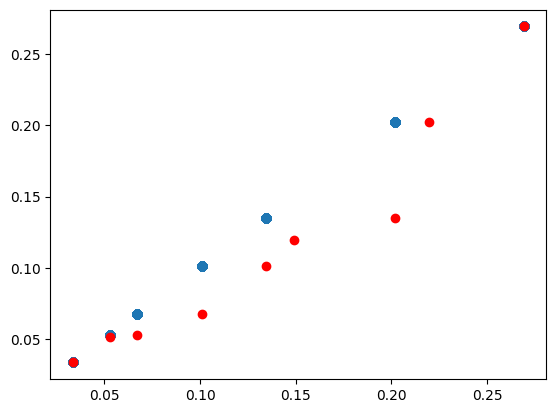

In [17]:
### Get Anchor Boxs
from utils.kmeans import kmeans, iou_dist, euclidean_dist
import numpy as np

all_boxes = train_label[2][train_label[2][..., 4] == 1][..., 2:4]
anchors = kmeans(
    all_boxes,
    n_cluster=9,
    dist_func=iou_dist,
    stop_dist=0.000001)

anchors = np.sort(anchors, axis=0)[::-1]
display(anchors)

import matplotlib.pyplot as plt

plt.scatter(all_boxes[..., 0], all_boxes[..., 1])
plt.scatter(anchors[..., 0],
            anchors[..., 1],
            c="red")
plt.show()

In [18]:
### Build NN Model from class
yolo = Yolo(class_names=class_names)
anchors=[[0.26923078, 0.26923078],
        [0.2626829 , 0.20192307],
        [0.20192307, 0.13508038],
        [0.13461539, 0.13461539],
        [0.10096154, 0.10096154],
        [0.07956883, 0.0673077 ],
        [0.0673077 , 0.05288462],
        [0.05288462, 0.03784578],
        [0.03365385, 0.03365385]]

yolo.create_model(anchors=anchors)
yolo.model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 416, 416, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 416, 416, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 416, 416, 32)         0         ['batch_normalization[

In [19]:
### Define Optimizer
from keras.optimizers import Adam
optimizer = Adam(learning_rate=5e-5)

In [20]:
### Leaning Rate Scheduling
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch <= 20:
        return lr
    elif epoch <= 70:
        return 3e-5
    else:
        return 1e-5

callback = LearningRateScheduler(scheduler)

In [21]:
#### Loss function from YOLO Class
from utils.tools import get_class_weight

binary_weight_list = []

for i in range(len(train_label)):
    binary_weight_list.append(
        get_class_weight(
        train_label[i][..., 4:5],
        method='binary'
        )
    )
print(binary_weight_list)

binary_weight_list = [0.1]*3


ignore_thresh = 0.7
use_focal_loss = True

loss_weight = {
    "xy":1,
    "wh":1,
    "conf":5,
    "prob":1
    }

loss_fn = yolo.loss(
    binary_weight_list,
    loss_weight=loss_weight,
    ignore_thresh=ignore_thresh
    )

[array([0.0369116]), array([0.00898685]), array([0.00223204])]


In [22]:
### Build Metrics from Yolo Class
metrics = yolo.metrics("obj+iou+class")


In [23]:
#### Model Compilation
yolo.model.compile(
    optimizer = optimizer,
    #optimizer=SGD(learning_rate=1e-10, momentum=0.9, decay=5e-4),
    loss = loss_fn,
    metrics = metrics
    )

In [24]:
### Model Training And Validation
train_history = yolo.model.fit(
    train_img,
    train_label,
    epochs = n_epoch,
    batch_size=5,
    verbose=1,
    validation_data=(valid_img, valid_label),
    callbacks=[callback]
    )

Epoch 1/10


200/200 [==============================] - 2189s 11s/step - loss: 965.4499 - concatenate_2_loss: 110.4549 - concatenate_3_loss: 195.8499 - concatenate_4_loss: 659.1446 - concatenate_2_obj_acc: 0.7257 - concatenate_2_mean_iou: 0.3102 - concatenate_2_class_acc: 0.1037 - concatenate_3_obj_acc: 0.7918 - concatenate_3_mean_iou: 0.3542 - concatenate_3_class_acc: 0.0964 - concatenate_4_obj_acc: 0.8105 - concatenate_4_mean_iou: 0.3236 - concatenate_4_class_acc: 0.1011 - val_loss: 300.1154 - val_concatenate_2_loss: 85.2784 - val_concatenate_3_loss: 95.1138 - val_concatenate_4_loss: 119.7232 - val_concatenate_2_obj_acc: 0.9663 - val_concatenate_2_mean_iou: 0.2775 - val_concatenate_2_class_acc: 0.1088 - val_concatenate_3_obj_acc: 0.9916 - val_concatenate_3_mean_iou: 0.4612 - val_concatenate_3_class_acc: 0.1063 - val_concatenate_4_obj_acc: 0.9979 - val_concatenate_4_mean_iou: 0.3926 - val_concatenate_4_class_acc: 0.1020 - lr: 5.0000e-05
Epoch 2/10
200/200 [============================

In [25]:
yolo.model.save('./weight_yolov3_1.h5')

d:\Number Plate Region\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


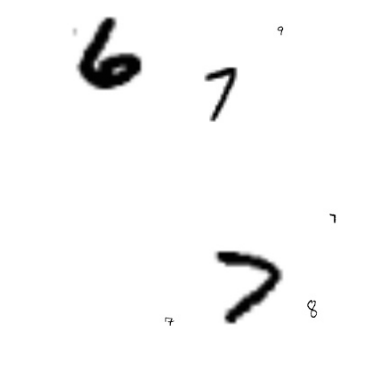

In [29]:
image = np.expand_dims(test_img[0], axis=0)
prediction = yolo.model.predict(image)

for i in range(len(image)):
    yolo_data.vis_img(
        image[i],
        prediction[2][i],
        prediction[1][i],
        prediction[0][i],
        conf_threshold=0.5,
        nms_mode=2,
        )